In [2]:
import IPython.display as ipd
from keras.src.layers import BatchNormalization, Activation
from tensorflow.python.layers.core import Dropout
from tensorflow.python.ops.gen_nn_ops import Conv2D

file_path = '/home/amirani/Desktop/file343/audio.flac'
ipd.Audio(filename=file_path)

2026-01-16 13:20:36.176870: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-16 13:20:36.177574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 13:20:36.327779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 13:20:39.367323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

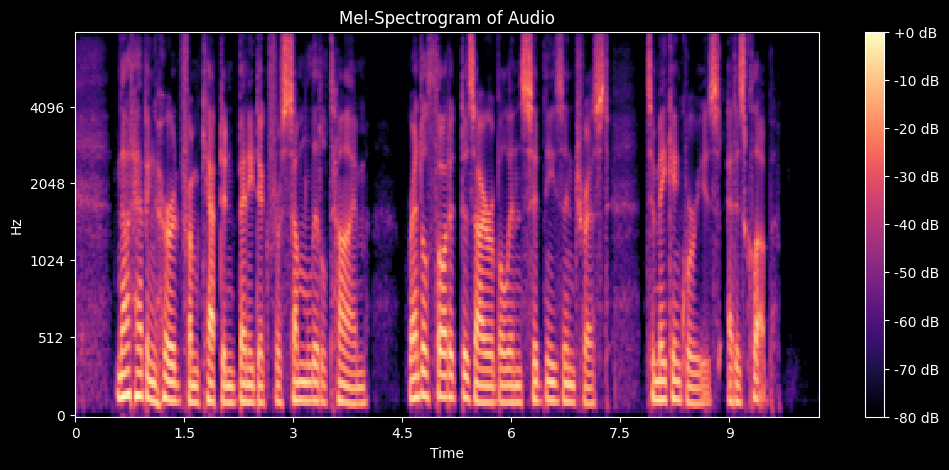

In [43]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


file_path = '/home/amirani/Desktop/file343/audio.flac'
text_path='/home/amirani/Desktop/txt'
text= open(text_path, 'rb').read().decode(encoding='utf-8')
alphabet = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ".", ",","\n"]
special_tokens = ["[pad]", "[start]", "[end]"]

vocab = special_tokens + alphabet
st_text=["[start]"]+list(text)
en_text=list(text)+["[end]"]

char_to_num = {char: i for i, char in enumerate(vocab)}
x_np=np.array([[char_to_num[char] for char in st_text]])
y_np=np.array([[char_to_num[char] for char in en_text]])



y, sr = librosa.load(file_path)


S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)


S_dB = librosa.power_to_db(S, ref=np.max)


plt.figure(figsize=(12, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram of Audio')
plt.show()

In [42]:
 print(S_dB.shape)

(128, 441)


In [48]:
X=S_dB

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Attention, Concatenate
from tensorflow.keras.models import Model
inputs = layers.Input(shape=(128, 441, 1))
x=Conv2D(filters=196,kernel_size=15,strides=4)(inputs)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(rate=0.8)(x)

shape=x.shape
x=layers.Reshape((shape[2],shape[1]*shape[3]))(x)

x, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(units=128, return_sequences=True, return_state=True))(x)
x=BatchNormalization()(x)
x=Dropout(rate=0.8)(x)
state_h_enc = Concatenate()([forward_h, backward_h]) # 128 + 128 = 256
state_c_enc = Concatenate()([forward_c, backward_c]) # 128 + 128 = 256
encoder_states = [state_h_enc, state_c_enc]
bi_lstm_out=x

decoder_inp = layers.Input(shape=(None,))
x = layers.Embedding(input_dim=len(vocab), output_dim=128)(decoder_inp)
decoder_out, state_h, state_c = layers.LSTM(256, return_sequences=True, return_state=True)(x, initial_state=encoder_states)

context_vector = layers.Attention()([decoder_out, bi_lstm_out])

combined = layers.Concatenate()([decoder_out, context_vector])


outputs = layers.Dense(40, activation='softmax')(combined)
model = tf.keras.Model(inputs=[inputs, decoder_inp], outputs=outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
X=np.expand_dims(X, axis=0)
model.fit(
    x=[X,x_np],
    y=y_np,
    batch_size=32,
    epochs=100,
)
pred=model.predict(x=[X,x_np])
predicted_indices = np.argmax(pred, axis=-1)
print(predicted_indices)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0145 - loss: 3.8302
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step - accuracy: 0.0145 - loss: 3.7856
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.0942 - loss: 3.7829
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - accuracy: 0.0435 - loss: 3.8635
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.0580 - loss: 3.6960
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - accuracy: 0.1377 - loss: 3.6949
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step - accuracy: 0.1377 - loss: 3.9248
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step - accuracy: 0.0362 - loss: 3.8900
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 0.1377 - loss: 3.6455
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - accuracy: 0.0580 - loss: 3.6487
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step - accuracy: 0.2029 - loss: 3.4717
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 0.